<a href="https://colab.research.google.com/github/rzuberi/cell-SCT/blob/main/Qualitative_comparison_of_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Qualitative comparison of masks

This notebooks demonstrates one of the techniques to compare the ground truth mask and the predicted mask qualitatively. This works by making a crop around each ground truth cells and making the same crops in the predicted mask.

If the cells in the predicted mask fall in the crop, that's a success.

This notebook will consist of two parts:
1. Showing the data we have (cell pictures, ground truth masks and predicted masks)
2. Showing the difference between the ground truth mask crops and these crops applied on the predictions.

##The data we have

In [2]:
#Extracting our imported data, channel 0 image with groundtruth and predicted mask
#TODO: Should probably change this to just get it from a local file instead of asking to upload zip file
import zipfile

with zipfile.ZipFile('/content/nuclei_images_demo.zip', 'r') as zip_ref: zip_ref.extractall('/content/nuclei_images_demo')

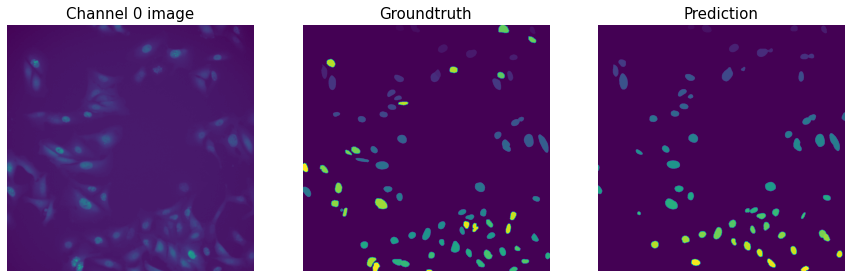

In [3]:
#Displaying our 3 images
from matplotlib import pyplot as plt
from PIL import Image, ImageSequence
import numpy as np

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Channel 0 image', fontsize=15)
plt.imshow(np.array(Image.open('/content/nuclei_images_demo/nuclei_images_demo/C0_Image.tiff')))

plt.subplot(1,3,2)
plt.axis('off')
plt.title('Groundtruth', fontsize=15)
seg = np.load('/content/nuclei_images_demo/nuclei_images_demo/Groundtruth_mask.npy', allow_pickle=True).item()
plt.imshow(seg['masks'].squeeze())

plt.subplot(1,3,3)
plt.axis('off')
plt.title('Prediction', fontsize=15)
seg = np.load('/content/nuclei_images_demo/nuclei_images_demo/Predicted_mask.npy', allow_pickle=True).item()
plt.imshow(seg['masks'].squeeze())
plt.show()


##The comparison

In [4]:
#All the code for getting the crop coordinates
import math
from math import hypot
import itertools
from itertools import combinations

#Function to get the number of cells in an image
#Input: image
#Output: number of cells
#The number of cells is defined by the number of different pixel intensities, excluding the background

def count_cells(img):
  numbers_found = []

  for i in range(len(img)):
    #if in one line of pixels there are only zeros, then there are no cells in that line
    current_line = img[i]
    if not np.all((current_line == 0)):
      for j in range(len(current_line)):
        if current_line[j] != 0: numbers_found.append(current_line[j])
  return len(set(numbers_found))


#Function to get the 4 coordinates of cell
#Input: binary image where cell is singled out
#Output: list withtop left coordinates, bottom left coordinates, top right coordinates, bottom right coordinates

def get_corners(binary):
  top_left_col, top_left_row = None, None
  bot_right_col, bot_right_row = None, None
  top_right_col, top_right_row = None, None
  bot_left_col, bot_left_row = None, None

  #Get the first True's row and column (top left)
  for i in range(len(binary)):
    if True in binary[i]:
      top_left_row = i
      for j in range(len(binary[i])):
        if binary[i][j] == True:
          top_left_col = j
          break
    if top_left_row != None and top_left_col != None: break

  #(bottom left)
  for i in range(len(binary)):
    if True in binary[i]:
      while i < 1080 and True in binary[i]: i+=1
      bot_left_row = i-1
      for j in range(len(binary[bot_left_row])):
        if binary[bot_left_row][j]:
          bot_left_col = j
          break
    if bot_left_row != None: break

  #Get the last True's row and column (bottom right)
  for i in range(len(binary)):
    if True in binary[i]:
      bot_right_row = i
      for j in range(len(binary[i])):
        if binary[i][j] == True:
          bot_right_col = j

  #Start reading from the columns (top right)
  for i in range(len(binary)):
    if True in binary[i]:
      top_right_row = i
      for j in range(len(binary[i])):
        if binary[i][j] == True:
          top_right_col = j        
    if top_right_row != None and top_right_col != None: break
  
  #print('xxxxx')

  return [(top_left_col,top_left_row),(bot_left_col,bot_left_row),(top_right_col,top_right_row),(bot_right_col,bot_right_row)]


#Function to get the center of a cell
#Input: 4 corners of a cell
#Output: coordinates of center of cell

def get_center(corners):

  x_coors = [corners[i][0] for i in range(4)]
  y_coors = [corners[i][1] for i in range(4)]
  center_col = int(sum(x_coors)/len(y_coors))
  center_row = int(sum(y_coors)/len(y_coors))

  return center_col,center_row


#Function to get the longest diagonal
#Input: 4 coordinates of cell
#Output: longest line between two points

def get_longest_line(corners):
  point_combinations = sum([list(map(list, combinations(corners, i))) for i in range(len(corners) + 1)], [])
  point_combinations = [combi for combi in point_combinations if len(combi)==2]

  longest = 0
  test = []
  for combi in point_combinations:
    current_len = math.hypot(combi[0][0] - combi[1][0], combi[0][1] - combi[1][1])
    test.append(current_len)
    if current_len > longest: longest = current_len
  
  return int(longest)


#Function that takes a mask and returns a crop of every cell inside of it
#Input: image of cells (mask)
#Output: list of images that are crops of the cells in the inputted image

def get_cell_crop_coordinates(original_cells_img):
  copy_cells_img = np.copy(original_cells_img)

  #get the number of nucleis
  num_cells = count_cells(copy_cells_img)

  crops = []
  crop_coordinates = []

  #loop through the number of nucleis
  for nuclei_num in range(1,num_cells+1):
    #print(str(nuclei_num)+'/'+str(num_cells))

    #get singled out cell image
    cell_img = np.copy(copy_cells_img)
    cell_img = cell_img == nuclei_num

    corners = get_corners(cell_img) #get the four corners of the nuclei

    center_col, center_row = get_center(corners) #get the center of the nuclei

    margin = 10
    crop_len = int(get_longest_line(corners)/2)+margin #get the longest diag and divide by 2 for square crop half length

    bottom_row = max(0,center_row-crop_len)
    top_row = min(copy_cells_img.shape[0]-1,center_row+crop_len)
    bottom_col = max(0,center_col-crop_len)
    top_col = min(copy_cells_img.shape[1]-1,center_col+crop_len)
    
    crop_coordinates.append([bottom_row,top_row,bottom_col,top_col]) #store the crop coordinates

    crops.append(cell_img[bottom_row:top_row,bottom_col:top_col]) #make the crop and store it in the list
    
  return crop_coordinates

#Function to get crops on image from list of coordinates
#Input: original image, list of coordinates to crop around(4)
#Output: crops of these coordinates

def get_img_crops(img,list_of_coordinates):
  crops = [] #where the cropped images will be stored
  for coor in list_of_coordinates:
    crops.append(img[coor[0]:coor[1],coor[2]:coor[3]])
  return crops

In [13]:
#Use the groundtruth mask and get the crop coordinates around cells

seg = np.load('/content/nuclei_images_demo/nuclei_images_demo/Groundtruth_mask.npy', allow_pickle=True).item()
gt_mask = seg['masks'].squeeze()

crop_coordinates_gt = get_cell_crop_coordinates(gt_mask)
img_crops = get_img_crops(gt_mask,crop_coordinates)

In [ ]:
for img in img_crops:
  plt.imshow(img),plt.show()

In [14]:
#Visual comparison of plots
#First column is the groundtruth cell crops, second column in the predicted cell crops, both made around the channel 0 image

#Get the crops from the predicted mask
seg = np.load('/content/nuclei_images_demo/nuclei_images_demo/Predicted_mask.npy', allow_pickle=True).item()
pred_mask = seg['masks'].squeeze()
crop_coordinates_pred = get_cell_crop_coordinates(pred_mask)

#Display these first 5 crops on the channel 0 image
chan0_img = np.array(Image.open('/content/nuclei_images_demo/nuclei_images_demo/C0_Image.tiff'))
img_crops_chan0_pred = get_img_crops(chan0_img,crop_coordinates_pred) 


#Get the crops from the groundtruth mask
crop_coordinates_gt = get_cell_crop_coordinates(gt_mask)
img_crops_chan0_gt = get_img_crops(chan0_img,crop_coordinates_gt)

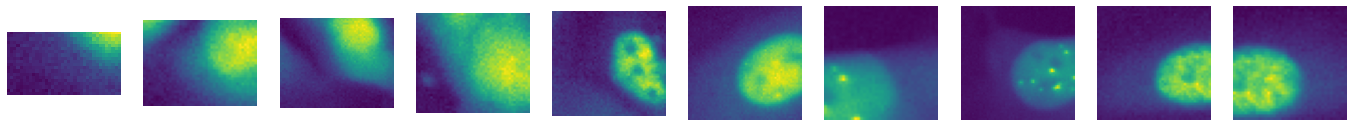

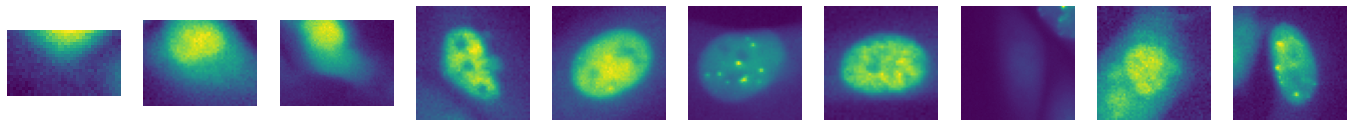

In [25]:
num_imgs_to_show = 10

#Predicted crops of first 5 cell nucleis on channel 0 image
plt.figure(figsize=(24,24))
plt.title('Prediction')
for i in range(num_imgs_to_show):
  plt.subplot(1,num_imgs_to_show,i+1)
  plt.imshow(img_crops_chan0_pred[i])
  plt.axis('off')
plt.show()

#Groundtruth crops of first 5 cell nucleis of channel 0 image

plt.figure(figsize=(24,24))
#plt.suptitle('Groundtruth')
plt.ylabel("Calorie Burnage")
for i in range(num_imgs_to_show):
  plt.subplot(1,num_imgs_to_show,i+1)
  plt.imshow(img_crops_chan0_gt[i])
  plt.axis('off')
plt.show()

#Would need to find a technique to match up these images together since they are not the same predictions
#As in, some kind of indexing needs to be done

In [ ]:
#Have to compare the number of ROIs as they may not be the same, which means certain groundtruth cells may not have been predicted
#The other way around works too where the predictions may have detected cells (correctly or not) that are not actually cells
#Could add a list at the top of this notebook that points out the negatives (the drawbacks) from this method (can bounding box the cell but not show the actual borders of the nuclei for example)

In [ ]:
#Selected strange cases where it did not work very well